In [29]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
import seaborn as sns
from ERANataf import ERANataf
from ERADist import ERADist

To be done:
Resampling
Check if the final steps is updated already
Log scale

In [18]:
"""
Cross Entropy for Bayesian updating
Comments 
W :  Importance weights of the Cross Entropy method W = phi/h
W_t : Importance weights of the improved Cross Entropy W_t = L**beta*W
----------------------------------------------------------------
Input
* N         : number of samples per level
* L_fun     : limit state function
* max_it    : maximum number of iterations
* Prior     : Nataf distribution object or marginal distribution
* CV_target :  target Coefficient of vairation of weights
----------------------------------------------------------------
Output
* Z         : normalisation constant
* lv        : total number of levels
* N_tot     : total number of samples
* samplesU  : object with the samples in the standard nromal space
* samplesX  : object with the samples in the original space
* beta_t    : intermediate tempering value
"""
def CEBU_SG(N,L_fun, prior, max_it,CV_target):
#     # initial check if there exists a Nataf object
#     if isinstance(prior, ERANataf):  # use Nataf transform (dependence)
#         dim = len(prior.Marginals)  # number of random variables (dimension)
#         u2x = lambda u: prior.U2X(u)  # from u to x

#     elif isinstance(prior, ERADist):  # use distribution information for the transformation (independence)
#         # Here we are assuming that all the parameters have the same distribution !!!
#         # Adjust accordingly otherwise
#         dim = 1  # number of random variables (dimension)
#         u2x = lambda u:prior.icdf(sp.stats.norm.cdf(u))  # from u to x
    dim = 1
    x2u = lambda x: (x-prior.mean())/prior.std()
    u2x = lambda u: prior.mean()+prior.std()*u
    L_transformed = lambda u: Likelihood(u2x(u))
    N_tot = 0
    mu_init = np.zeros(dim)
    si_init = np.identity(dim)
    beta_t = np.zeros(max_it)
    samplesU = list()
    # CE procedure
    mu_U = mu_init
    si_U = si_init
    # Iteration
    for t in range(max_it):
        # Generate samples and save them
        U = sp.stats.multivariate_normal.rvs(mean=mu_U,cov=si_U,size=N).reshape(-1,dim)
        samplesU.append(U.T)

        # Evaluate the likelihood function
        Leval = L_transformed(U)
        # Initialize beta, beta increases from 0 to 1
        if t==0 :
            beta_t[t] = 0
        else:
            beta_t[t] = beta_new

        # calculatiing h for the likelihood weight
        h = sp.stats.multivariate_normal.pdf(U,mu_U,si_U)
        phi = sp.stats.multivariate_normal.pdf(U,mean=np.zeros(dim),cov = np.identity(dim))
        W = phi/h
        if beta_t[t] >= 1-1e-6:
            break
        # Count generated samples
        N_tot += N
        
        Wt_fun = lambda beta: W*np.power(Leval,beta)[:,0]
        CV_Wt_fun = lambda beta: np.std(Wt_fun(beta))/np.mean(Wt_fun(beta))
        ESS_target = N/(1+CV_target**2)
        ESS_observed = lambda beta: N/(1+(CV_Wt_fun(beta))**2)
        #fmin = lambda beta: abs(ESS_target-ESS_observed(beta))
        fmin = lambda beta: np.linalg.norm((ESS_target-ESS_observed(beta))**2)
        beta_new = sp.optimize.fminbound(fmin,beta_t[t],1)
        # Update W_t
        W_t = Wt_fun(beta_new)
        delta_Wt = np.std(W_t)/np.mean(W_t)
        # Parameter update: closed form
        mu_U = W_t@U/sum(W_t)
        Xtmp = U-mu_U
        Xo = Xtmp *np.tile(np.sqrt(W_t),(dim,1)).T
        Si_U = np.matmul(Xo.T,Xo)/np.sum(W_t)+1e-6*np.identity(dim) 
    # total levels
    lv = t
    # Calculate the integral of the posterior Integral = sum(W_t)/N
    Z = sum(W_t)/N
    # Transform the samples to the physical/ original space
    samplesX = list()
    for i in range(lv):
        samplesX.append(u2x(samplesU[i]))
    return Z,lv,N_tot,samplesU,samplesX,beta_t 
    
    


## Example 1: Conjugate prior (mean) of the normal distribution

In [24]:
# This is an example where prior p(mu) ~ N(0,1),
mu_theta_prior, sigma_theta_prior = -10, 1
prior = lambda theta: sp.stats.norm.pdf(theta,loc = mu_theta_prior, scale = sigma_theta_prior)
dist_prior = ERADist("Normal","MOM",[mu_theta_prior,sigma_theta_prior])
log_prior = lambda theta: sp.stats.norm.logpdf(theta,loc=mu_theta_prior,scale = sigma_theta_prior)
# Likelihood functions p(D|mu) ~ normal
data = np.random.randn(10)
np.mean(data)#data.size
# Likelihood function
def Likelihood(theta):
    total_likelihood = 1
    sigma_X  = 1
    for i in range(data.size):
        total_likelihood = total_likelihood*sp.stats.norm.pdf(data[i],loc = theta, scale = sigma_X)
    return total_likelihood
def log_Likelihood(theta):
    total_likelihood = 0
    sigma_X  = 1
    for i in range(data.size):
        total_likelihood = total_likelihood+sp.stats.norm.logpdf(data[i],loc = theta, scale = sigma_X)
    return total_likelihood
# Posterior distribution
def target_dist(theta):
    return prior(theta)*Likelihood(theta)

def log_target_dist(theta):
    return log_prior(theta)+log_Likelihood(theta)



## Reference solution
#### Analytical solution

In [25]:
def posterior_analytical(mu_theta_prior,sigma_theta_prior,data):
    n = data.size
    x_bar = np.mean(data)
    sigma_X = 1
    mu_theta_posterior = (mu_theta_prior/sigma_theta_prior**2+n*x_bar/sigma_X**2)/(1/sigma_theta_prior**2+n/sigma_X**2)
    sigma_theta_posterior = (1/sigma_theta_prior**2+n/sigma_X**2)**(-1/2)
    return sp.stats.norm.pdf(theta,loc = mu_theta_posterior, scale = sigma_theta_posterior)

## Reference solution
#### Numerical integral

In [26]:
constant = sp.integrate.quad(target_dist,-np.inf,np.inf)
constant

(2.8178509179615962e-27, 4.328048312339776e-28)

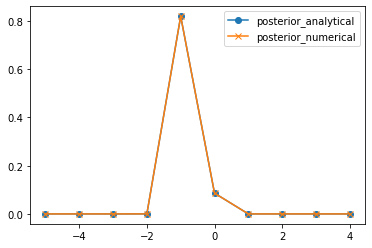

In [27]:
theta = np.arange(-5,5)
plt.plot(theta,posterior_analytical(mu_theta_prior,sigma_theta_prior,data),'-o',label='posterior_analytical')
plt.plot(theta,target_dist(theta)/constant[0],'-x',label='posterior_numerical')
plt.legend()

## CEBU

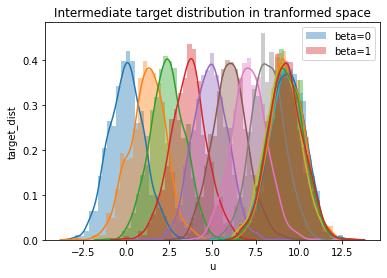

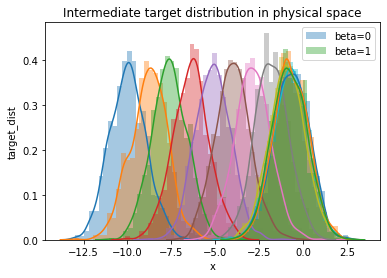

In [28]:
N = 1000
max_it = 50
CV_target = 1.5
dim = 1
# # Method 2 numerical integration of the denominator
# # constant = sp.integrate.quad(target_dist,-np.inf,np.inf)
# constant = sp.integrate.quad(target_dist,0,100)
[Z,lv,N_tot,samplesU,samplesX,beta_t] = CEBU_SG(N,Likelihood,dist_prior,max_it,CV_target)
# Plot samples 
if dim == 1:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    sns.distplot(samplesU[0],label='beta=0')
    for sample in samplesU[1:-1]:
        sns.distplot(sample)
        #plt.plot(*sample,".",markersize=2)
    sns.distplot(samplesU[-1],label='beta=1')
    plt.xlabel('u')
    plt.ylabel('target_dist')
    plt.title('Intermediate target distribution in tranformed space')
    plt.legend()
    plt.show()
if dim == 1:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    sns.distplot(samplesX[0],label='beta=0')
    for sample in samplesX[1:-1]:
        sns.distplot(sample)
        #plt.plot(*sample,".",markersize=2)
    sns.distplot(samplesX[-1],label='beta=1')
    plt.xlabel('x')
    plt.ylabel('target_dist')
    plt.title('Intermediate target distribution in physical space')
    plt.legend()
    plt.show()

In [ ]:
## Reference solution
#### Analytical solution
#### Numerical integral

## Example 2: crack model with only one Random Variable

In [3]:
# Parameter definition
# Fixed parameters
m = 3.5
C = np.exp(-1.5667*m - 27.5166)
a_0 = 0.10
t = 50 # lifetime
mu_DS , sigma_DS = 60,10
a = lambda DS: ((1-m/2)*C*DS**m*(np.pi)**(m/2)*10**5 * t + a_0**(1-m/2))**((1-m/2)**(-1))
prior = lambda DS: sp.stats.norm.pdf(DS,loc = mu_DS,scale=sigma_DS)
dist_prior = ERADist("Normal","MOM",[mu_DS,sigma_DS])
# Likelihood function
a_star = a(70)
a_tilde = np.random.normal(a_star, 0.01, 10)
def Likelihood(DS):
    total_likelihood = 1
    for i in range(a_tilde.size):
        total_likelihood = total_likelihood * sp.stats.norm.pdf(a(DS) - a_tilde[i], loc=0, scale =0.01)
    return total_likelihood
def target_dist(DS):
    return prior(DS)*Likelihood(DS)

## Reference solution
#### Numerical integral

In [4]:
constant = sp.integrate.quad(target_dist,0,100)
constant

(286501417849515.1, 3239247.2725675395)

## CEBU

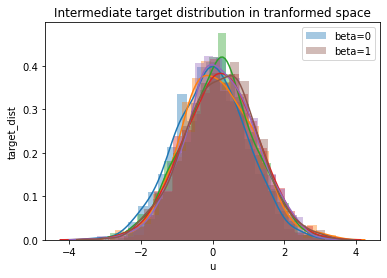

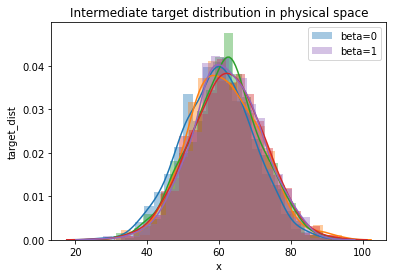

In [5]:
N = 1000
max_it = 50
CV_target = 1.5
dim = 1
# # Method 2 numerical integration of the denominator
# # constant = sp.integrate.quad(target_dist,-np.inf,np.inf)
# constant = sp.integrate.quad(target_dist,0,100)

[Z,lv,N_tot,samplesU,samplesX,beta_t] = CEBU_SG(N,Likelihood,dist_prior,max_it,CV_target)
# Plot samples 
if dim == 1:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    sns.distplot(samplesU[0],label='beta=0')
    for sample in samplesU[1:-1]:
        sns.distplot(sample)
        #plt.plot(*sample,".",markersize=2)
    sns.distplot(samplesU[-1],label='beta=1')
    plt.xlabel('u')
    plt.ylabel('target_dist')
    plt.title('Intermediate target distribution in tranformed space')
    plt.legend()
    plt.show()
if dim == 1:
    nnp = 200
    xx = np.linspace(-6,6,nnp)
    sns.distplot(samplesX[0],label='beta=0')
    for sample in samplesX[1:-1]:
        sns.distplot(sample)
        #plt.plot(*sample,".",markersize=2)
    sns.distplot(samplesX[-1],label='beta=1')
    plt.xlabel('x')
    plt.ylabel('target_dist')
    plt.title('Intermediate target distribution in physical space')
    plt.legend()
    plt.show()